## CPCA for fMRI - Matlab


### Get Data
### https://github.com/rzlim08/CPCA_Example

If you have git

git clone https://github.com/rzlim08/CPCA_Example

if not, you can download the zip file

#### Imports and Dependencies

First add the packages that we'll need. I'll try to use as few dependencies as possible here. The only thing we should need in matlab is spm for its reading functions (spm_vol, spm_read_vols). Later releases of matlab have built-in functions for this. Jimmy Shen's toolbox also is a good option https://www.mathworks.com/matlabcentral/fileexchange/8797-tools-for-nifti-and-analyze-image


#### Dependencies

Jupyter Notebook 

Matlab 

imatlab kernel

spm12

In [1]:
% Change this path to point to your SPM
addpath(genpath([pwd filesep 'dependencies']));

#### Data
We'll also need to the data, so make sure we have a reference to that too. 

We can use the Matlab 'dir' function to read in all the images. The \*.img string reads in all the files that end in '.img'

In [2]:
% Change this path to point to your data
data_path = [pwd filesep 'example_data_Single_Subject'  filesep 'example_data_Single_Subject'];
image_path = [data_path filesep 's01'];
scans = dir([image_path filesep '*.img'])


scans = 

  214×1 struct array with fields:

    name
    folder
    date
    bytes
    isdir
    datenum



We can see there are 214 scans for this subject. We now want to get a reference to all the images and store them in a way that matlab can read. We'll use the SPM functions 'spm_vol' and 'spm_read_vols' to read the headers and images respectively. So we will read a single scan in. 

In [3]:
scan = scans(1);
ss_path = [scan.folder filesep scan.name]; % Older versions of matlab won't have scan.folder, use image_path instead
ss_hdr = spm_vol(ss_path)


ss_hdr = 

  struct with fields:

      fname: '/home/rzlim08/CPCA_Example/example_data_Single_Subject/example_data_Single_Subject/s01/fsnruna_F001.img'
        dim: [40 48 34]
         dt: [4 0]
      pinfo: [3×1 double]
        mat: [4×4 double]
          n: [1 1]
    descrip: 'spm - 3D normalized - conv (8,8,8)'
    private: [1×1 nifti]



In [4]:
ss_img = spm_read_vols(ss_hdr);

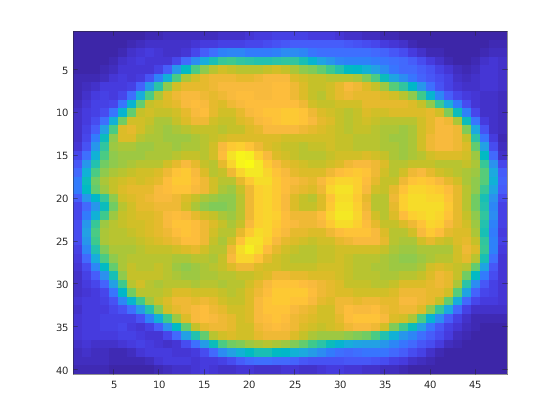

In [5]:
%% THIS SHOULD WORK WHEN ON A COMPUTER THAT SUPPORTS IT
imatlab_export_fig('print-png')
imagesc(squeeze(ss_img(:,:,17)))

Ok, so we have one image loaded in, we'll need to load all the images. 

In [6]:
path_to_scans = {};
for i = 1:size(scans)
    path_to_scans{end+1} = [scans(i).folder filesep scans(i).name];
end
% create a cell array of a path to each scan
path_to_scans = path_to_scans';
% read in scan headers
scan_hdr = spm_vol(path_to_scans);

So now we have a cell array storing the spm headers for all the images. We want to read those in and append them together to form a 2 dimensional matrix. We can use Matlab's cellfun for this.

In [7]:
 read_and_reshape = @(im_hdr)(reshape(spm_read_vols(im_hdr), 1,[]));
 im_cell = cellfun(read_and_reshape, scan_hdr, 'UniformOutput', 0);
 brain_scans = cell2mat(im_cell);

In [8]:
size(brain_scans)


ans =

         214       65280



## Masking 

There are infinite ways of creating an image mask. An mask is an image of zeros and ones that denote the areas to be analyzed. We will use a precreated mask for the purpose of this analysis, but we can easily make our own masking function. For example, we can create a mask by thresholding the scans at the global mean. 

In [9]:
global_mean = mean(mean(brain_scans))
thresholded = brain_scans>global_mean;


global_mean =

   5.8343e+03



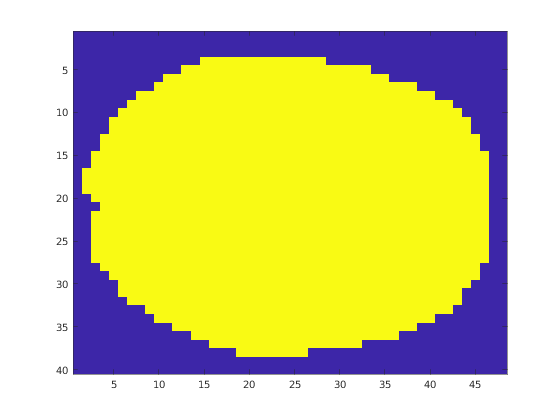

In [10]:
% for each voxel, if every scan is above the global mean, include the voxel in the analysis
mask_test = floor(sum(thresholded)/size(brain_scans,1)); 
m = reshape(mask_test, ss_hdr.dim);
imagesc(m(:,:,17))


In [11]:
% find where all scans are one, and take those out of the brain scans
masked_im = brain_scans(:, find(mask_test));
size(masked_im)



ans =

         214       29401



For the purposes of this workshop, we'll use a precreated mask.

In [12]:
% read in and flatten mask
mask = read_and_reshape(spm_vol([data_path filesep 'mask.img']));

To get our data matrix, we will select only the voxels that we've included in our analysis. We call our data matrix Z. 

In [13]:
Z = brain_scans(:, find(mask));
size(Z)


ans =

         214       29151



We will want to standardize this matrix. PCA should be mean centered at the very least to return meaningful results. 

In [14]:
Z = zscore(Z, 1);

In [15]:
all(abs(mean(Z))<0.01)
all(abs(std(Z)-1)<0.01)


ans =

  logical

   1


ans =

  logical

   1



This gives us a standardized data matrix. We will now create a design matrix to represent the timing information

## Creating the Design Matrix (G Matrix)

Since we want to get the neural responses to the task, we want to constain our analysis to the scans where we expect to see these responses. We create our design matrix by inserting ones into the places where we expect to see signals. This is a similar procedure to that used in SPM's first level analysis. 

In [16]:
Letters2=[55.269 79.074 89.123 118.569 123.266 138.011 163.450 179.190 189.245];
Letters4=[5.025 10.383 20.765 69.681 74.377 108.515 132.986 158.425 199.293];
Letters6=[15.740 25.789 40.540 143.369 148.727 168.808 173.832 183.887 194.269];
Letters8=[30.486 35.844 45.237 59.960 64.656 84.098 94.481 113.211 128.290];
onsets = {Letters2; Letters4; Letters6; Letters8};
onsets = cellfun(@ceil, onsets, 'UniformOutput', 0);

In [17]:
conditions = size(onsets,1)
bins = 8
G = zeros(size(Z,1), bins*conditions);
% For each condition
for j = 1:conditions
    cond_onsets = onsets{j};
    % For each onset
    for i = 1:size(cond_onsets,2)
        % Take the scan at the time of the onset, and the next 7 scans after, insert ones into these scans
        G(cond_onsets(i):cond_onsets(i)+bins-1, ...
            (j-1)*bins+1:(j-1)*bins+bins) = ...
            G(cond_onsets(i):cond_onsets(i)+bins-1, ...
            (j-1)*bins+1:(j-1)*bins+bins)|...
            eye(bins);
    end
end


conditions =

     4


bins =

     8



In [18]:
a = calculate_hrf_shape([Letters2' ones(9, 1)*10], 214, 3);
b = calculate_hrf_shape([Letters4' ones(9, 1)*10], 214, 3);
c = calculate_hrf_shape([Letters6' ones(9, 1)*10], 214, 3);
d = calculate_hrf_shape([Letters8' ones(9, 1)*10], 214, 3);
plot([a b c])
title('HRF shape estimation for design')
xlabel('scans')
ylabel('hrf')

Undefined function 'spm_get_bf' for input arguments of type 'struct'.

Error in calculate_hrf_shape (line 11)
    SPM.xBF = spm_get_bf( SPM.xBF ); 


Now we have a design matrix for each of the different conditions and onsets. Finally, we want to standardize the G matrix. 

In [19]:
G = zscore(G,1);

## Regression

We will then regress the Z matrix onto the G matrix. This will give use the betas for the regression. 

In [20]:
% This uses Matlab's mldivide function. 
% We can also use the normal equations, which seem to work faster in Matlab 2016a
C = G\Z;  

## SVD/PCA

Now we can do the singular value decomposition (SVD). SVD is a matrix decomposition technique that will yield equivalent results to PCA. Normally, with multiple participants we'd have to append all the matrices from each participant together, but here we only have a single participant. 

In [21]:
disp(['rank of Z = ', num2str(rank(Z))])
disp(['rank of GC = ' num2str(rank(G*C))]) % The rank of GC is equal to the rank of G. Thus we can see this as projecting Z onto a lower dimensional space
[U D V] = svds(G*C, 3);
% Create predictor weights by regressing the eigenvectors onto the design matrix and multiplying by the sqrt of 
% the number of scans
P = (G\U)*sqrt(size(G,1));

rank of Z = 213
rank of GC = 32


Now we can make very disappointing plots of the predictor weights, since we only have one participant. 


p_conds =

    0.0952    0.1970    0.1042    0.4241
    0.0502    0.2178    0.1599    0.5151
   -0.1064    0.1626    0.1731    0.5357
   -0.1463    0.0767    0.0150    0.4153
   -0.1487    0.1048   -0.0580    0.3117
   -0.2322    0.0999   -0.1564    0.1802
   -0.3084    0.0708   -0.2651    0.0687
   -0.2706    0.0503   -0.2965    0.0488



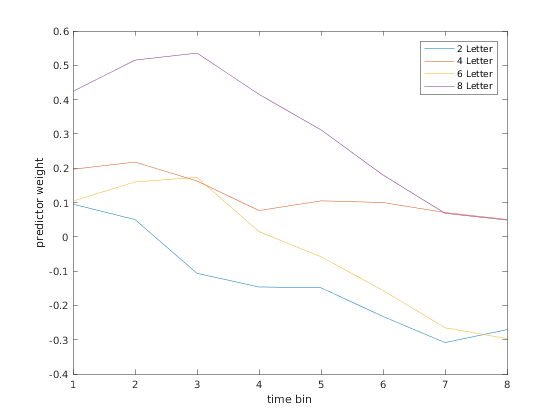

In [22]:
p_conds = reshape(P(:, 1), [8, 4])
plot(p_conds)
xlabel('time bin')
ylabel('predictor weight')
legend('2 Letter','4 Letter', '6 Letter', '8 Letter')


p_conds =

    0.2564    0.2600    0.2923   -0.0094
    0.1499    0.2260    0.2941    0.1602
   -0.0661    0.1367    0.3929    0.2149
   -0.2812   -0.0807    0.1993    0.0197
   -0.1534   -0.0539    0.0553   -0.1619
   -0.0045    0.0915    0.1037   -0.2416
   -0.1664    0.0308   -0.1553   -0.4894
   -0.0925   -0.0375   -0.1887   -0.4943



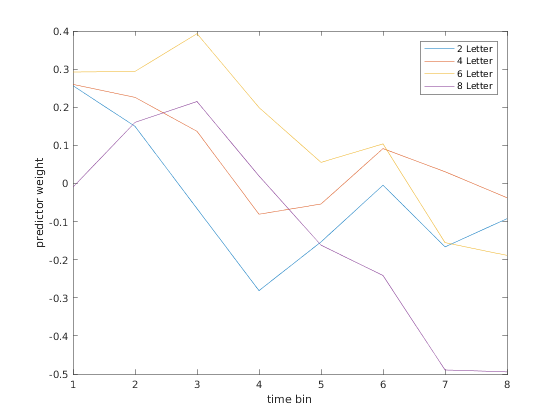

In [23]:
p_conds = reshape(P(:, 2), [8, 4])
plot(p_conds)
xlabel('time bin')
ylabel('predictor weight')
legend('2 Letter','4 Letter', '6 Letter', '8 Letter')


p_conds =

   -0.0607   -0.0816    0.0238   -0.1103
    0.0787   -0.0295   -0.0232   -0.0858
    0.2327    0.1106    0.2534    0.2685
    0.2646    0.2340    0.6149    0.6412
    0.3080    0.2626    0.5566    0.5615
    0.3433    0.1721    0.4566    0.3726
    0.3606    0.1504    0.3961    0.2551
    0.2758    0.1335    0.2914    0.1426



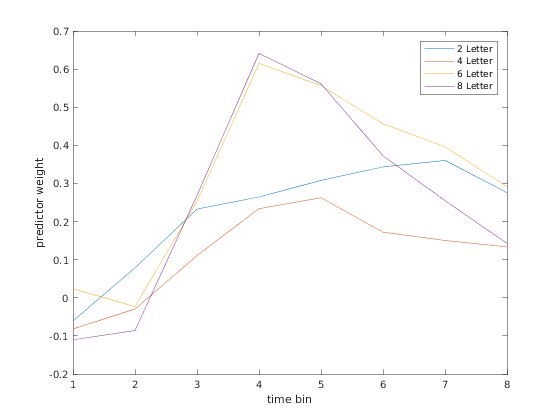

In [24]:
p_conds = reshape(P(:, 3), [8, 4])
plot(p_conds)
xlabel('time bin')
ylabel('predictor weight')
legend('2 Letter','4 Letter', '6 Letter', '8 Letter')

## Extras

Exploring the Impact of Analysis Software on Task fMRI Results

 https://doi.org/10.1101/285585